In [14]:
import numpy as np
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

### Данные:
Будем работать с датасетом [The Iris Dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).

In [4]:
from sklearn.datasets import load_iris

In [5]:
data = load_iris()

In [6]:
X, y = data['data'], data['target']

In [7]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

### Задание:
Будем решать задачу классификации на 3 класса. В качестве модели используется нейронная сеть с одним скрытым слоем. Ваша задача оценить качество решенения задачи классификации по метрике `accuracy` в зависимости от числа нейронов скрытого слоя. Также оцените дисперсию функции качества в зависимости от числа главных компонент.

Нарисуйте график зависимости функции качества и ее дисперсии от числа нейронов скрытого слоя.

In [8]:
def baseline_model(hidden_width=8):
    # create model
    model = Sequential()
    model.add(Dense(hidden_width, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

In [10]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [9]:
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print(results)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.93333334 1.         1.         1.         1.         0.86666667
 0.86666667 1.         1.         1.        ]
Baseline: 96.67% (5.37%)


In [10]:
param_grid={"hidden_width": list(range(1,10))}
grid = GridSearchCV(estimator=estimator,param_grid=param_grid, cv=kfold, verbose=1)
result = grid.fit(X, dummy_y)
print(result)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 11.0min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4dda8e3be0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_width': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)


In [11]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))
test_means = result.cv_results_['mean_test_score']
test_stds = result.cv_results_['std_test_score']

Best: 0.980000 using {'hidden_width': 5}


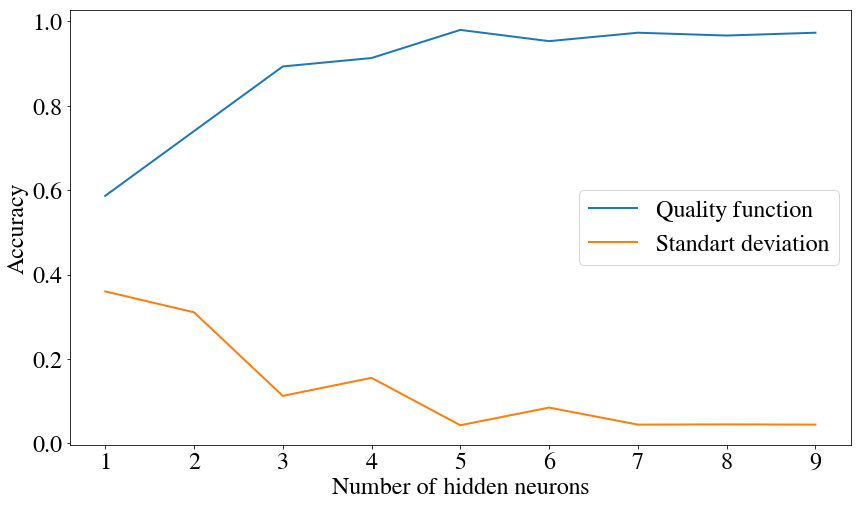

In [17]:
plt.figure(figsize=(14,8))
plt.plot(param_grid["hidden_width"], means, label="Quality function")
plt.plot(param_grid["hidden_width"], stds, label="Standart deviation")
plt.xlabel("Number of hidden neurons")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Homework 3
### Dependence of the error value and its standard deviation on the sample size on training and validation.

In [46]:
train_std = []
train_mean = []
test_mean = []
test_std = []
data_range = np.linspace(10,len(X), 10, dtype='int')
for k in data_range:
    results = cross_validate(estimator, X[:k,:], dummy_y[:k,:], cv=kfold)
    train_std.append(results['train_score'].std())
    train_mean.append(results['train_score'].mean())
    test_std.append(results['test_score'].std())
    test_mean.append(results['test_score'].mean())
    print('*')

/home/sn0wbars/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


*
*
*
*
*
*
*
*
*
*


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9523258538172172, 0.9717333813808336, 0.9718044092463067, 0.9755555569021791]


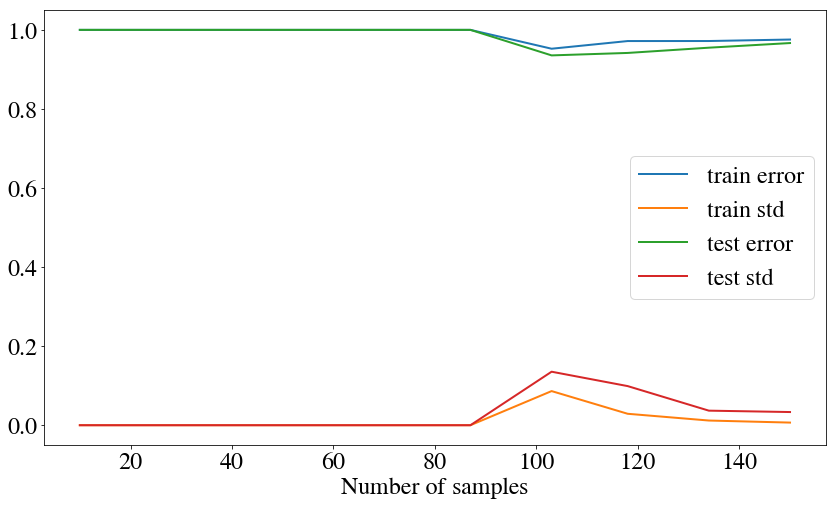

<Figure size 432x288 with 0 Axes>

In [49]:
print(train_mean)
plt.figure(figsize=(14,8))
plt.plot(data_range, train_mean, label="train error")
plt.plot(data_range, train_std, label="train std")
plt.plot(data_range, test_mean, label="test error")
plt.plot(data_range, test_std, label="test std")
plt.xlabel("Number of samples")
plt.legend()
plt.show()
plt.savefig('plot.png')